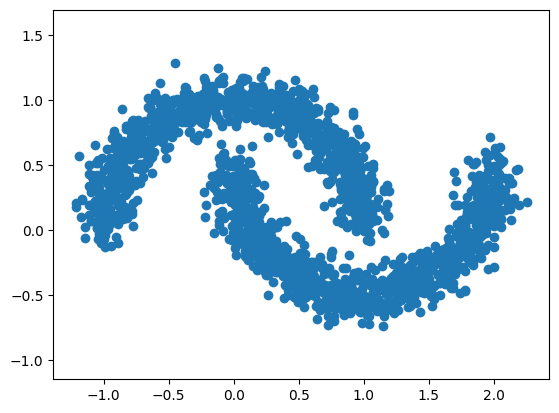

In [1]:
from sklearn.datasets import make_moons, make_circles
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

# Generate the dataset
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [2]:
device = "cpu"
# device = "mps" # apple metal
# device = "cuda"

In [3]:
def loss(net, batch):
    bsz = batch.shape[0]

    x0 = torch.randn(bsz, 2, device=device) # random noise
    x1 = batch # real data
    
    t = torch.rand(bsz, 1, device=device) # time ~ U(0, 1)

    # interpolate between x0 and x1
    xt = (1 - t) * x0 + t * x1

    # target is the velocity, the time-derivative of the interpolant
    target = x1 - x0

    pred = net(torch.cat([xt, t], dim=1))

    return torch.mean((pred - target) ** 2)

@torch.no_grad()
def sample(net, bsz):
    x0 = torch.randn(bsz, 2, device=device)

    num_steps = 200
    dt = 1 / num_steps

    x = x0
    t = torch.zeros(bsz, 1, device=device)
    traj = [x.clone().cpu().numpy()]

    # follow the velocity field
    for i in range(num_steps):
        vel = net(torch.cat([x, t], dim=1))
        x += vel * dt
        t += dt

        traj.append(x.clone().cpu().numpy())
    
    return x.cpu().numpy(), np.array(traj)

In [4]:
# define the neural network:
# 4-layer ReLU network with hidden dimension 512

d = 512
net = nn.Sequential(
    nn.Linear(3, d),
    nn.ReLU(),
    nn.Linear(d, d),
    nn.ReLU(),
    nn.Linear(d, d),
    nn.ReLU(),
    nn.Linear(d, 2),
).to(device)

Epoch 0, Loss: 1.5682404722486223


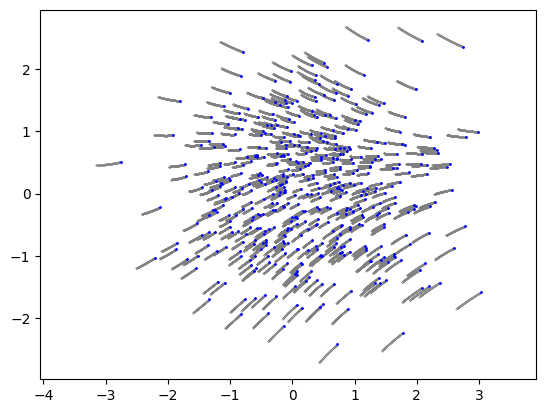

Epoch 100, Loss: 0.9698761105537415


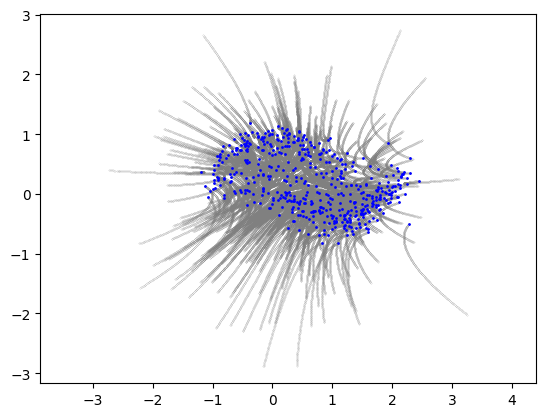

Epoch 200, Loss: 0.9973192981311253


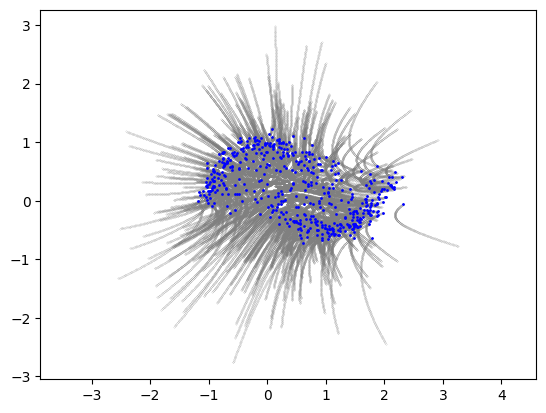

Epoch 300, Loss: 1.038932468209948


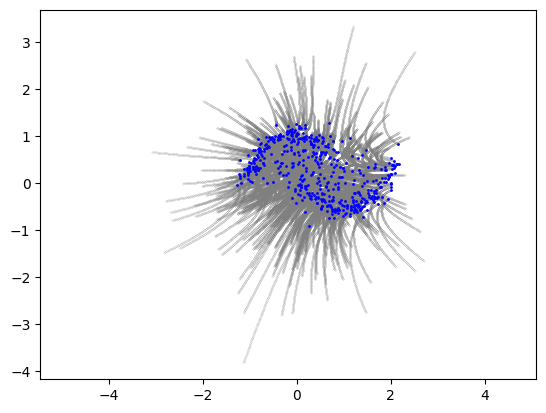

Epoch 400, Loss: 1.0087872743606567


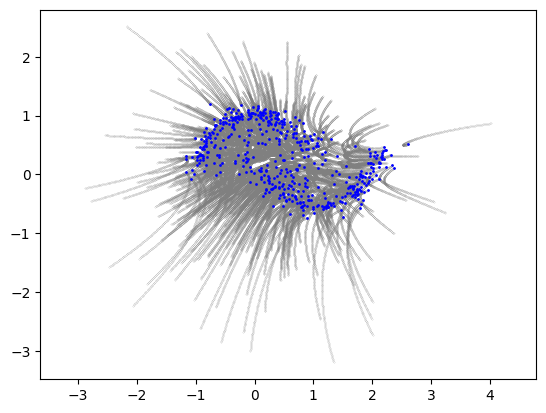

Epoch 500, Loss: 1.0033350672040666


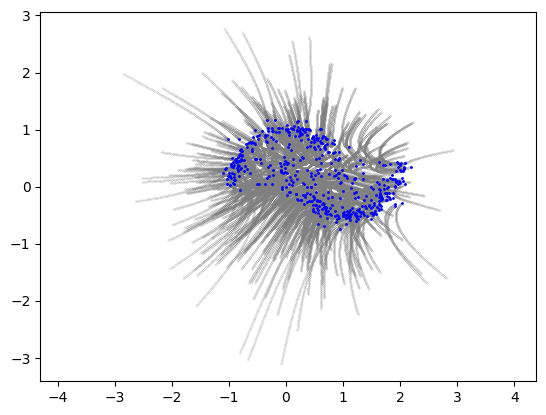

In [5]:
# training loop
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

epochs = 500
vis_every_n_epochs = 100
bsz = 256  # batch size
num_batches = X.shape[0] // bsz

losses = []

for epoch in range(epochs+1):
    perm = torch.randperm(X.shape[0])
    epoch_loss = 0
    for i in range(num_batches):
        indices = perm[i * bsz:(i + 1) * bsz]
        batch = torch.tensor(X[indices], dtype=torch.float32, device=device)
        
        opt.zero_grad()
        l = loss(net, batch)
        l.backward()
        opt.step()
        
        epoch_loss += l.item()

    epoch_loss /= num_batches
    losses.append(epoch_loss)

    if epoch % vis_every_n_epochs == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss}")
        samples, traj = sample(net, 500)
        plt.scatter(traj.reshape(-1, 2)[:,0], traj.reshape(-1, 2)[:,1], s=0.01, color='grey')
        plt.plot(samples[:, 0], samples[:, 1], 'bo', markersize=1)
        plt.axis('equal')
        plt.show()

# each sampling trajectory from noise to data is in gray
# the blue dots are the samples from the learned distribution

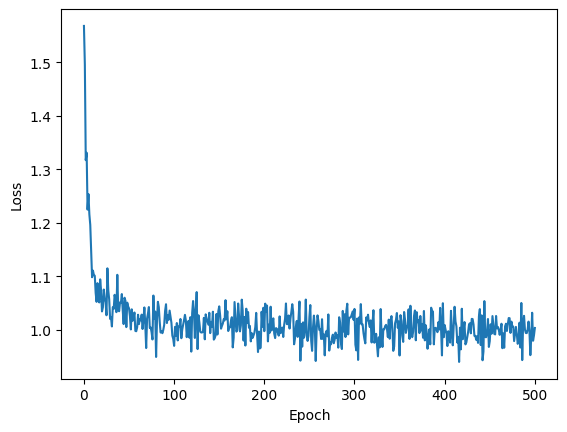

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss");

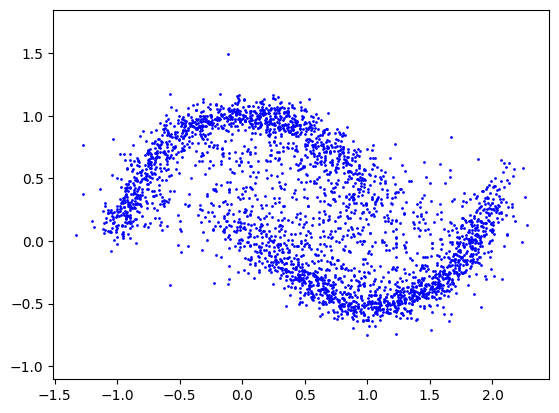

In [7]:
# generate some samples
samples, traj = sample(net, 3000)
plt.axis('equal')
plt.plot(samples[:, 0], samples[:, 1], 'bo', markersize=1);

# things you can try

- change the noise distribution to a gaussian with different mean and stdev
- make the model conditional on which moon it is by providing label `y` as an input to the neural network
- increase or decrease the size of the neural network
- increase or decrease training length
- try training with GPU on colab
- change the dataset to make_circles: `X, y = make_circles(n_samples=2000, noise=0.03, random_state=42, factor=0.5)`
- increase or decrease the number of steps used during sampling